In [191]:
import numpy as np
import numpy
import pyscf
import pyscf.gto
import pyscf.qmmm
import pyscf.scf
import matplotlib.pyplot as plt
import functools

@functools.lru_cache(100)
def spc(lval):
    mol = pyscf.gto.M(atom='H 0 0 0.; H 0 0 1.', basis='def2-TZVP', verbose=0)
    deltaZ = np.array((1, -1))*lval

    calc = pyscf.scf.RHF(mol)
    calc.conv_tol = 1e-14
    calc.conv_tol_grad = 1e-12

    mf = pyscf.qmmm.mm_charge(calc, mol.atom_coords()/(1 / 0.52917721067), deltaZ)  
    class NoSelfQMMM(mf.__class__):
            def energy_nuc(self):
                    return (1+deltaZ[0])*(1+deltaZ[1])/(1/0.52917721067)
    mf = NoSelfQMMM()
    hfe=mf.kernel(direct=False)
    mycc = pyscf.cc.CCSD(mf)
    mycc.conv_tol = 1e-12
    mycc.run()

    dm1 = mycc.make_rdm1()
    dm1_ao = np.einsum('pi,ij,qj->pq', mf.mo_coeff, dm1, mf.mo_coeff.conj())
    epns = []
    for site in (0, 1):
        mol.set_rinv_orig_(mol.atom_coords()[site])
        epns.append(np.matmul( dm1_ao,mol.intor('int1e_rinv')).trace())
    return epns
spc(0)

[1.5848731221192567, 1.584873122119257]

In [142]:
@functools.lru_cache(1)
def refval():
    mol = pyscf.gto.M(atom='He 0 0 0.', basis='aug-cc-pvdz', verbose=0)
    calc = pyscf.scf.RHF(mol)
    calc.conv_tol = 1e-12
    calc.conv_tol_grad = 1e-10
    calc.run()
    mycc = pyscf.cc.CCSD(calc)
    mycc.conv_tol = 1e-10
    mycc.run()
    return mycc.e_tot
refval()

-2.8895484850650557

In [192]:
def dE(lval):
    es = spc(lval)
    return es[0]-es[1]

In [193]:
import findiff

In [194]:
def get_fd_coefficients(order):
    if order == 0:
        return [0], [1]
    delta = 0.01
    cs = findiff.coefficients(deriv=order, acc=order)['center']
    return cs['offsets']*delta, cs['coefficients']/(delta**order)

In [195]:
def get_order(order):
    E = 0.
    for lval, weight in zip(*get_fd_coefficients(order)):
        E += dE(lval) * weight
    return -E

In [196]:
def get_orders(upto):
    factorial = [1, 1, 2, 6, 6*4,6*4*5, 6*4*5*6, 6*4*5*6*7]
    evals = [get_order(0)]
    for order in range(1, upto):
        evals.append(evals[-1]+get_order(order) / factorial[order])
    return evals

In [197]:
es = get_orders(8)

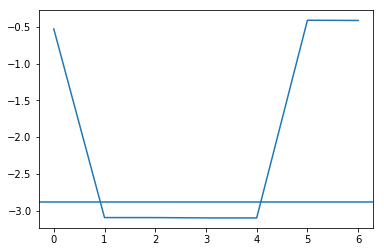

In [198]:
plt.plot(np.array(es[:7]) - 1/(1/0.52917721067))
plt.axhline(refval())

### Interpolate?

In [187]:
xs = np.linspace(-0.2, 0.2, 10)
ys = [dE(_) for _ in xs]

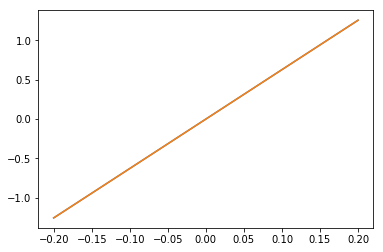

In [188]:
plt.plot(xs, ys)
coeff = np.polyfit(xs, ys, 3)
poly = np.poly1d(coeff)
xss = np.linspace(-0.2, 0.2, 100)
yss = poly(xss)
plt.plot(xss, yss)

In [180]:
def dE(lval):
    return poly(lval)